### 数据准备工作
- 基础的数据读入问题

In [ ]:
%%bash
cp /content/drive/MyDrive/2021MCMProblemC_DataSet.xlsx -rf /content/

In [ ]:
dir = '/content/2021MCMProblemC_DataSet.xlsx'
import pandas as pd

df = pd.read_excel(dir)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4440 entries, 0 to 4439
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GlobalID         4440 non-null   object        
 1   Detection Date   4440 non-null   object        
 2   Notes            4440 non-null   object        
 3   Lab Status       4440 non-null   object        
 4   Lab Comments     4438 non-null   object        
 5   Submission Date  4440 non-null   datetime64[ns]
 6   Latitude         4440 non-null   float64       
 7   Longitude        4440 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 277.6+ KB


In [ ]:
df["Lab Status"].value_counts()

Unverified     2342
Negative ID    2069
Unprocessed      15
Positive ID      14
Name: Lab Status, dtype: int64

In [ ]:
# positiveData 中存放lab Status是positive id
positiveData = df[df['Lab Status'].isin(['Positive ID'])]
positiveData['Lab Status'].value_counts()

print("below is the positive data info")
positiveData.info()

below is the positive data info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 4338
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GlobalID         14 non-null     object        
 1   Detection Date   14 non-null     object        
 2   Notes            14 non-null     object        
 3   Lab Status       14 non-null     object        
 4   Lab Comments     14 non-null     object        
 5   Submission Date  14 non-null     datetime64[ns]
 6   Latitude         14 non-null     float64       
 7   Longitude        14 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 1008.0+ bytes


In [ ]:
cleanedData = df.loc[:,['GlobalID','Detection Date','Notes','Lab Status','Lab Comments','Latitude','Longitude']]
cleanedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4440 entries, 0 to 4439
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GlobalID        4440 non-null   object 
 1   Detection Date  4440 non-null   object 
 2   Notes           4440 non-null   object 
 3   Lab Status      4440 non-null   object 
 4   Lab Comments    4438 non-null   object 
 5   Latitude        4440 non-null   float64
 6   Longitude       4440 non-null   float64
dtypes: float64(2), object(5)
memory usage: 242.9+ KB


### 处理日期数据Dectection Date
- 处理好不符合规定的Dectection Date

In [ ]:
from datetime import datetime
import re

dataCleaned2 = pd.DataFrame(columns=['GlobalID','Detection Date','Notes','Lab Status','Lab Comments','Latitude','Longitude'])

for index, row in cleanedData.iterrows():
  match = re.search(r'\d{4}-\d{1,2}-\d{1,2}', str(row["Detection Date"]))
  if match == None:
    continue
  tmp = datetime.strptime(match.group(), '%Y-%m-%d').date()
  month = tmp.month
  year = tmp.year
  day = tmp.day
  dataCleaned2 = dataCleaned2.append({'GlobalID':row["GlobalID"],'Detection Date':row["Detection Date"],'Notes':row["Notes"],'Lab Status':row["Lab Status"],'Lab Comments':row["Lab Comments"],'Latitude':row["Latitude"],'Longitude':row["Longitude"]},ignore_index=True)

In [ ]:
dataCleaned2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4426 entries, 0 to 4425
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   GlobalID        4426 non-null   object        
 1   Detection Date  4426 non-null   datetime64[ns]
 2   Notes           4426 non-null   object        
 3   Lab Status      4426 non-null   object        
 4   Lab Comments    4424 non-null   object        
 5   Latitude        4426 non-null   float64       
 6   Longitude       4426 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 242.2+ KB


In [ ]:
dataCleaned2.to_csv("cleaned_data_VM.csv", index=False)

In [ ]:
positiveData = dataCleaned2[dataCleaned2['Lab Status'].isin(['Positive ID'])]
positiveData['Lab Status'].value_counts()

print("below is the positive data info")
positiveData.info()

below is the positive data info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 4325
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   GlobalID        14 non-null     object        
 1   Detection Date  14 non-null     datetime64[ns]
 2   Notes           14 non-null     object        
 3   Lab Status      14 non-null     object        
 4   Lab Comments    14 non-null     object        
 5   Latitude        14 non-null     float64       
 6   Longitude       14 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 896.0+ bytes


In [ ]:
positiveData.to_csv("positive.csv", index=False)

### 根据地理位置进行聚类
- 使用经度纬度进行一次聚类
- 根据时间梳理出现的个数，使用excel实现

In [ ]:
%%bash
pip install kneed

### 分析14个positive例子
- 已知了一个蜂窝位置
- 计算其他所有点和这个蜂窝位置的距离
- 这里主要是做的事位置方面的聚类

In [ ]:
from math import radians, cos, sin, asin, sqrt

def geo_distance(lon1, lat1, lon2, lat2):  #地理距离
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(radians, map(float, [lon1, lat1, lon2, lat2]))  #根据提供的函数对指定序列做映，radians:将角度转换为弧度。
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

distance = []

centerla = 49.149394
centerlo = -123.943134

for index,row in positiveData.iterrows():
  la = row["Latitude"]
  lo = row["Longitude"]
  distance.append(geo_distance(lo,la,centerlo,centerla))

print(distance)


[93.30312612421889, 92.6326566792523, 0.0, 95.88277413703294, 83.60541197647672, 95.26034430651583, 118.72626737560653, 92.03111711693589, 90.75240789063088, 101.361248154428, 100.9963172316743, 100.83181799009736, 101.3696742368978, 101.36822993204541]


In [ ]:
positiveData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 4325
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   GlobalID        14 non-null     object        
 1   Detection Date  14 non-null     datetime64[ns]
 2   Notes           14 non-null     object        
 3   Lab Status      14 non-null     object        
 4   Lab Comments    14 non-null     object        
 5   Latitude        14 non-null     float64       
 6   Longitude       14 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 896.0+ bytes


In [ ]:
positiveData2 = positiveData.loc[:, ['Latitude','Longitude','Detection Date']]

In [ ]:
positiveData2.to_csv("input.txt", index=False)

#### 分析
1. 因为这个这个蜂窝和其他发现的黄蜂之间的距离 > 8km（补充材料中说明这是黄蜂最大发现的一个距离），所以这些黄蜂应该是在其他地方还有窝点
2. 删除蜂窝的位置坐标的数据，对于其他的零散数据进行聚类分析，+-8,不大于16km, 
所以最后分析出来的数据两个经纬度之间差距不会超过16km
3. 由于提供经纬度坐标计算两者之间的距离和普通的计算不相同，所以这里只能使用自己的python文件


In [ ]:
%%bash
pip3 install hdbscan

  Using cached https://files.pythonhosted.org/packages/32/bb/59a75bc5ac66a9b4f9b8f979e4545af0e98bb1ca4e6ae96b3b956b554223/hdbscan-0.8.27.tar.gz
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp36-cp36m-linux_x86_64.whl size=2311392 sha256=75f8181b1dba539dbcb7c8e169a1703a135b1ffce9742578bf3e5421e31e76e0
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan


In [ ]:
import hdbscan
import numpy as np
df3 = pd.read_csv("input.txt")
df3 = df3.loc[:, ["Latitude", "Longitude"]]
points = np.array(df3)
rads = np.radians(points)
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='haversine')
cluster_labels = clusterer.fit_predict(points)

In [ ]:
print(cluster_labels)

[ 0  0 -1  0 -1 -1 -1  0 -1  1  1  1  1  1]


In [ ]:
from pandas.core.frame import DataFrame
df4 = pd.read_csv("input.txt") 
setCluster = set(cluster_labels)
dicCluster = {"label":cluster_labels}
dfCluster = DataFrame(dicCluster)
dfConcat = pd.concat([df3, dfCluster], axis=1)

In [ ]:
dfConcat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   14 non-null     float64
 1   Longitude  14 non-null     float64
 2   label      14 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 464.0 bytes


In [ ]:
dfConcat.to_csv("dfConcat.result", index=False)

In [ ]:
dfCluster1 = np.array(dfConcat[dfConcat['label'].isin([-1])])
dfCluster2 = np.array(dfConcat[dfConcat['label'].isin([0])])
dfCluster3 = np.array(dfConcat[dfConcat['label'].isin([1])])
dfCluster4 = np.array(dfConcat[dfConcat['label'].isin([2])])
dflist = [dfCluster1, dfCluster2, dfCluster3, dfCluster4]
for dfName in dflist:
  print(dfName)
  print(type(dfName))

[[  49.149394 -123.943134   -1.      ]
 [  49.025831 -122.810653   -1.      ]
 [  49.060215 -122.641648   -1.      ]
 [  48.777534 -122.418612   -1.      ]
 [  48.927519 -122.745016   -1.      ]]
<class 'numpy.ndarray'>
[[  48.980994 -122.688503    0.      ]
 [  48.971949 -122.700941    0.      ]
 [  48.955587 -122.661037    0.      ]
 [  48.993892 -122.702242    0.      ]]
<class 'numpy.ndarray'>
[[  48.984269 -122.574809    1.      ]
 [  48.979497 -122.581335    1.      ]
 [  48.983375 -122.582465    1.      ]
 [  48.984172 -122.57472     1.      ]
 [  48.98422  -122.574726    1.      ]]
<class 'numpy.ndarray'>
[]
<class 'numpy.ndarray'>


In [ ]:
dflist = [dfCluster1, dfCluster2, dfCluster3, dfCluster4]
for dfName in dflist:
  [rows, cols] = dfName.shape
  print(rows, cols)
  print("this is dfName part start")
  for i in range(rows):
    la = dfName[i][0]
    lo = dfName[i][1]
    sign = 0
    for j in range(rows):
      if j == i:
        continue
      la2 = dfName[j][0]
      lo2 = dfName[j][1]
      distancetmp = geo_distance(lo, la, lo2, la2)
      print(distancetmp, end='\t')
      if distancetmp < 16:
        sign = 1
        break
    if sign == 0:
      print("this node does not qualify")
    print("")

5 3
this is dfName part start
83.60541197647854	95.26034430651768	118.72626737560827	90.75240789063426	this node does not qualify

83.60541197647854	12.898027674633044	
95.26034430651768	12.898027674633044	
118.72626737560827	39.79238436853365	35.40629127813077	29.128617197125383	this node does not qualify

90.75240789063426	11.93536418603599	
4 3
this is dfName part start
1.3548523639440426	
1.3548523639440426	
3.46426162828179	
1.7498431011458744	
5 3
this is dfName part start
0.7130019424951126	
0.7130019424951126	
0.5674649205790073	
0.012590322823963232	
0.008146873900023879	
0 3
this is dfName part start


#### 分析总结
- 可以发现后面三个的聚类都非常好
- 聚类都在距离都在2，3千米的位置
- 但是第一个聚类没有很好

In [ ]:
# 计算第一个聚类和其他的最短距离
[rows, cols] = dfCluster1.shape
for i in range(rows):
  la = dfCluster1[i][0]
  lo = dfCluster1[i][1]
  sign = 0
  curdisshortest = 100000
  print("start this node computing")
  for j in range(rows):
    if j == i:
      continue
    la2 = dfCluster1[j][0]
    lo2 = dfCluster1[j][1]
    distancetmp = geo_distance(lo, la, lo2, la2)
    print(distancetmp, end='\t')
    curdisshortest = min(curdisshortest, distancetmp)
    if distancetmp < 16:
      sign = 1
      break
  if sign == 0:
    print("this node does not qualify")
  print("\n" + str(curdisshortest))

start this node computing
83.60541197647854	95.26034430651768	118.72626737560827	90.75240789063426	this node does not qualify

83.60541197647854
start this node computing
83.60541197647854	12.898027674633044	
12.898027674633044
start this node computing
95.26034430651768	12.898027674633044	
12.898027674633044
start this node computing
118.72626737560827	39.79238436853365	35.40629127813077	29.128617197125383	this node does not qualify

29.128617197125383
start this node computing
90.75240789063426	11.93536418603599	
11.93536418603599


#### 分析结论
- 观测得出之间的距离都非常远
- 也许都不是一个源点

### 时间序列模型
- 时间序列模型基本绘图
- 时间序列模型,由于ARMA更容易适合于比较大的数据集中，所以这里选择比较简单的模型

In [ ]:
positiveData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 4325
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   GlobalID        14 non-null     object        
 1   Detection Date  14 non-null     datetime64[ns]
 2   Notes           14 non-null     object        
 3   Lab Status      14 non-null     object        
 4   Lab Comments    14 non-null     object        
 5   Latitude        14 non-null     float64       
 6   Longitude       14 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 896.0+ bytes


                     0
2019-09-30   92.031117
2019-10-30   92.632657
2019-11-13   83.605412
2019-12-08   93.303126
2020-05-15   95.260344
2020-05-27   95.882774
2020-06-07  118.726267
2020-08-17   90.752408
2020-09-21  101.361248
2020-09-28  101.368230
2020-09-29  101.369674
2020-09-30  100.996317
2020-10-01  100.831818
DatetimeIndex(['2019-09-30', '2019-10-30', '2019-11-13', '2019-12-08',
               '2020-05-15', '2020-05-27', '2020-06-07', '2020-08-17',
               '2020-09-21', '2020-09-28', '2020-09-29', '2020-09-30',
               '2020-10-01'],
              dtype='datetime64[ns]', freq=None)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


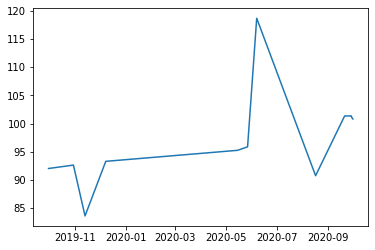

In [ ]:
# 随时间变化和开始蜂窝点（2019.9.19发现的）的距离
import matplotlib.pyplot as plt
originLa = 49.149394
originLo = -123.943134

positiveDic = {}
positiveData.sort_values("Detection Date",inplace=True)
for index,row in positiveData.iterrows():
  la = row["Latitude"]
  lo = row["Longitude"]
  distmp = geo_distance(lo,la,originLo, originLa)
  if distmp == 0:
    continue
  positiveDic[row["Detection Date"]] = distmp

df4 = pd.DataFrame.from_dict(positiveDic, orient='index')
print(df4)
# df4["num"].plot()
ts = df4[0]
print(df4.index)
plt.plot(ts)

In [ ]:
positiveData.to_csv("looktmp")

2019
19-09
2019
19-09
2019
19-10
2019
19-11
2019
19-12
2020
20-05
2020
20-05
2020
20-06
2020
20-08
2020
20-09
2020
20-09
2020
20-09
2020
20-09
2020
20-10
Index(['19-07', '19-08', '19-09', '19-10', '19-11', '19-12', '20-05', '20-06',
       '20-08', '20-09', '20-10'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


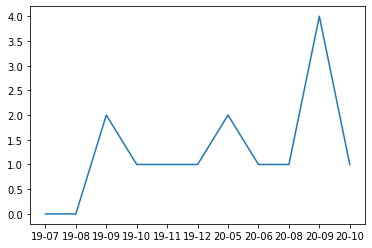

In [ ]:
# 随时间变化黄蜂数量的增长
import matplotlib.pyplot as plt
originLa = 49.149394
originLo = -123.943134


positiveDic2 = {}
positiveDic2["19-07"]=0
positiveDic2["19-08"]=0
positiveData.sort_values("Detection Date",inplace=True)
for index,row in positiveData.iterrows():
  row["Detection Date"]
  match = re.search(r'\d{4}-\d{1,2}-\d{1,2}', str(row["Detection Date"]))
  tmp = datetime.strptime(match.group(), '%Y-%m-%d').date()
  month = tmp.month
  year = tmp.year
  print(year)
  thistime = str(year)[2:4] +"-"+ str(month).zfill(2)
  print(thistime)
  if thistime not in positiveDic2:
    positiveDic2[thistime] = 1
  else:
    positiveDic2[thistime] += 1
  

df4 = pd.DataFrame.from_dict(positiveDic2, orient='index')
df4.to_excel("resultNum.xls", index=False)
# df4["num"].plot()
ts = df4[0]
print(df4.index)
plt.plot(ts)

In [ ]:
df4 = pd.read_csv("input.txt") 
print(df4.head())

    Latitude   Longitude Detection Date
0  48.980994 -122.688503     2019-12-08
1  48.971949 -122.700941     2019-10-30
2  49.149394 -123.943134     2019-09-19
3  48.955587 -122.661037     2020-05-27
4  49.025831 -122.810653     2019-11-13


In [ ]:
df4.index

RangeIndex(start=0, stop=14, step=1)

In [ ]:
%%bash
pip install pyramid-arima

In [ ]:
from pyramid.arima import auto_arima
import re
dflist = []

for index, row in df4.iterrows():
  match = re.search(r'\d{4}-\d{1,2}-\d{1,2}', str(row["Detection Date"]))
  tmp = datetime.strptime(match.group(), '%Y-%m-%d').date()
  month = tmp.month
  year = tmp.year

  newmonth = float(month)
  if year == 2020:
    newmonth += 12
  dflist.append(newmonth)

c={"a" :dflist}
data=DataFrame(c)

df4.drop(columns="Detection Date", inplace=True)
train = pd.concat([df4, data], axis=1)
#　print(train)
train1 = df4.drop(columns=["Latitude"])
train2 = df4.drop(columns=["Longitude"])

KeyError: ignored

In [ ]:
train = train1[:int(0.7*(len(data)))]
valid = train1[int(0.7*(len(data))):]

In [ ]:
train1.head()

,Longitude
0,-122.688503
1,-122.700941
2,-123.943134
3,-122.661037
4,-122.810653


In [ ]:
train2.head()

,Latitude
0,48.980994
1,48.971949
2,49.149394
3,48.955587
4,49.025831


Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=22.266, BIC=26.100, Fit time=0.180 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=14.273, BIC=15.551, Fit time=0.021 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=16.273, BIC=18.190, Fit time=0.041 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=16.273, BIC=18.190, Fit time=0.050 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=18.273, BIC=20.829, Fit time=0.102 seconds
Total fit time: 0.399 seconds


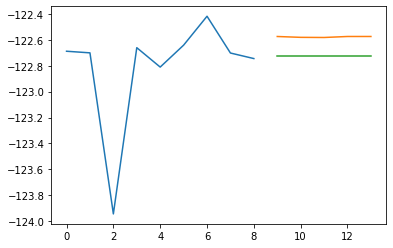

In [ ]:
model = auto_arima(train1, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train1)
 
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])
 
#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
 
rms = sqrt(mean_squared_error(valid,forecast))
print(rms)

0.15099011404441381


In [ ]:
from pyramid.arima import auto_arima